# Localization_Classification.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## 3. Localization & Classification

In [1]:
#Import the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import  random as rand
from sklearn.externals import joblib
import csv

CLASSIFY_DIM = (128,128)

In [2]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

75


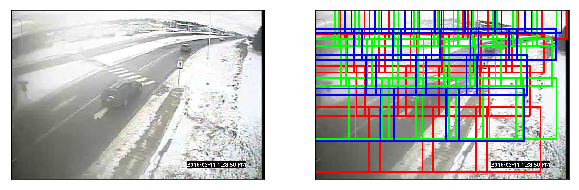

In [3]:
#Class containging the rectangle shape
class rectangle():
    def __init__(self,x,y,w,h,color):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.color = color

#sliding window
def slidingWindow(img):
    windows = []
    scaleFactor = 1.3
    squareSize = 40
    overlap = 1.2
    
    color = [[255,0,0],[0,255,0],[0,0,255]]
    initialSizeOfRectangles = [  #Convention is [xwin,ywin,wwin,hwin]
        [0,0,int(squareSize/342 * img.shape[1]),int(squareSize/342 * img.shape[1]),color[0]], #SQUARE
        [0,0,int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[1]], #VERTICAL RECTANGLE
        [0,0,int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[2]], #VERTICAL RECTANGLE
    ]
    
    
    #Initialize the starting sliding window
    for inital in initialSizeOfRectangles:
        xwin = inital[0]
        ywin = inital[1]
        wwin = inital[2]
        hwin = inital[3]
        col = inital[4]
        while ywin < img.shape[1]:
            for xwin in range(0,img.shape[1],int(wwin/overlap)):
                if (img.shape[1] - xwin) < wwin or (img.shape[0] - ywin) < hwin :
                    continue
                patch = rectangle(xwin,ywin,wwin,hwin,col)
                windows.append(patch)

            #Update sliding window parameters
            ywin = int(ywin + hwin/overlap)
            hwin = int(hwin * scaleFactor)
            wwin = int(wwin * scaleFactor)
    
    
    return windows

img = cv2.imread("./MIO-TCD-Localization/MIO-TCD-Localization/train/00000009.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
windows = slidingWindow(img)
print(len(windows))
img1 = img.copy()

for sw in windows:
    cv2.rectangle(img1, (sw.x, sw.y) ,(sw.x + sw.w, sw.y + sw.h), sw.color, 3)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(img1)
plt.xticks([]), plt.yticks([])
plt.show()



In [4]:
#Load classifier 
#load path
loadingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
name = "SVMclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier SVM...",end="")
start = time.time()
#clfSVM = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")

loadingPath = "./Classifiers/Kneigh/"
clfFileType = ".clf"
name = "Kneighclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier Kneigh...",end="")
start = time.time()
clfKneigh = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")



Presently loading classifier SVM...DONE! (Time taken: 4.1961669921875e-05 sec)
Presently loading classifier Kneigh...DONE! (Time taken: 47.47272491455078 sec)


[6] [255, 0, 0]
[10] [255, 0, 0]
[6] [255, 0, 0]
[3] [255, 0, 0]
[6] [0, 255, 0]
[6] [0, 255, 0]
[8] [0, 0, 255]
[3] [0, 0, 255]


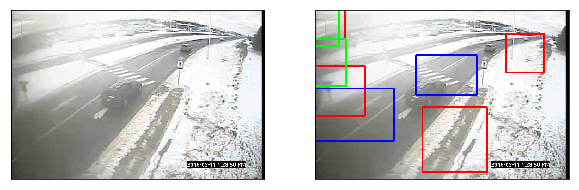

In [5]:
#predict
cs = (4,4)
bs = (2,2)
nbins = 8
predictedLabels = []
img1 = img.copy()
for sw in windows:
    patch = img[sw.y:sw.y + sw.h, sw.x:sw.x + sw.w] 
    patch = cv2.resize(patch,CLASSIFY_DIM)
    hog = HoGFromImage(patch,cs,bs,nbins)
    hog = hog.reshape(1,-1)
    labelKneigh = clfKneigh.predict(hog)
    
    if(labelKneigh and labelKneigh != 1 ):
        print(labelKneigh, sw.color)
        predictedLabels.append(labelKneigh)
        cv2.rectangle(img1, (sw.x, sw.y) ,(sw.x + sw.w, sw.y + sw.h), sw.color, 3)
    

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(img1)
plt.xticks([]), plt.yticks([])
plt.show()
